In [38]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets,transforms
from torchinfo import summary
from torchvision.transforms import ToTensor
from transformers import ViTForImageClassification, ViTImageProcessor
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm
from PIL import Image
import random
from collections import defaultdict

In [39]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Get the current device (GPU)
    device = torch.device("cuda:0")
    # Get the name of the GPU
    gpu_name = torch.cuda.get_device_name(device)
    # Get the total memory of the GPU
    gpu_properties = torch.cuda.get_device_properties(device)
    total_memory = gpu_properties.total_memory / (1024 ** 3)  # Convert bytes to GB
    
    print(f"Using GPU: {gpu_name}")
    print(f"Total GPU memory: {total_memory:.2f} GB")
else:
    print("No GPU available. Using CPU.")
    device = torch.device("cpu")


Using GPU: Tesla P100-PCIE-16GB
Total GPU memory: 15.89 GB


In [40]:
import torch.nn as nn

class MultiLayerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob=0.5):
        super(MultiLayerClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_prob))  # Dropout layer
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.classifier = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.classifier(x)


In [41]:
# Load the pretrained ViT model and processor
model_name = "google/vit-base-patch16-224-in21k"
pretrained_vit = ViTForImageClassification.from_pretrained(model_name).to(device)
processor = ViTImageProcessor.from_pretrained(model_name)

# Modify the classifier head
class_names = ['0', '1', '2', '3', '4', '5', '6']
num_classes = len(class_names)

input_dim = 768  # Dimension of [CLS] token embedding
hidden_dims = [512,256]  # Example hidden layers
output_dim = len(class_names)  # Number of classes
multi_layer_classifier = MultiLayerClassifier(input_dim, hidden_dims, output_dim).to(device)

#pretrained_vit.classifier = nn.Linear(in_features=768, out_features=num_classes).to(device)
pretrained_vit.classifier = multi_layer_classifier

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Print a summary using torchinfo
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
ViTForImageClassification (ViTForImageClassification)                  [32, 3, 224, 224]    [32, 7]              --                   True
├─ViTModel (vit)                                                       [32, 3, 224, 224]    [32, 197, 768]       --                   True
│    └─ViTEmbeddings (embeddings)                                      [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    │    └─ViTPatchEmbeddings (patch_embeddings)                      [32, 3, 224, 224]    [32, 196, 768]       590,592              True
│    │    └─Dropout (dropout)                                          [32, 197, 768]       [32, 197, 768]       --                   --
│    └─ViTEncoder (encoder)                                            [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─ModuleList (

In [43]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None, max_samples_per_class=None):
        self.dataset = dataset
        self.transform = transform
        self.max_samples_per_class = max_samples_per_class
        
        if self.max_samples_per_class:
            self.dataset = self.undersample_dataset()

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        if img.mode == 'L':
            img = np.stack([img] * 3, axis=-1)
            img = Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def undersample_dataset(self):
        class_indices = defaultdict(list)
        
        for idx, (_, label) in enumerate(self.dataset):
            class_indices[label].append(idx)
        
        undersampled_indices = []
        
        for label, indices in class_indices.items():
            if self.max_samples_per_class < len(indices):
                undersampled_indices.extend(random.sample(indices, self.max_samples_per_class))
            else:
                undersampled_indices.extend(indices)
        
        undersampled_dataset = torch.utils.data.Subset(self.dataset, undersampled_indices)
        return undersampled_dataset


In [44]:
def create_dataloaders(data_dir: str, processor, batch_size: int, validation_split: float=0.2, max_samples_per_class=None):
    # Load the full dataset
    full_dataset = datasets.ImageFolder(data_dir)
    
    # Apply the CustomDataset with class size restriction to the full dataset
    restricted_dataset = CustomDataset(full_dataset, max_samples_per_class=max_samples_per_class)
    
    # Calculate sizes for training and validation splits
    dataset_size = len(restricted_dataset)
    val_size = int(validation_split * dataset_size)
    train_size = dataset_size - val_size
    
    # Split restricted dataset into training and validation subsets
    train_dataset, val_dataset = random_split(restricted_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(123))
    
    # Define transformations with the processor applied inside the transformation pipeline
    train_transforms_with_processor = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomAffine(degrees=0, shear=15),
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda img: processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0))

    ])
    
    val_transforms_with_processor = transforms.Compose([
        transforms.Lambda(lambda img: processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)),
    ])
    
    # Reapply the CustomDataset with the transformations
    train_dataset = CustomDataset(train_dataset, transform=train_transforms_with_processor)
    val_dataset = CustomDataset(val_dataset, transform=val_transforms_with_processor)
    
    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    class_names = full_dataset.classes  # class names from the original dataset
    
    return train_dataloader, val_dataloader, class_names


In [45]:
path = '/kaggle/input/affectnet-data/Data/Data'
#path = '/kaggle/input/affectnet-data/Demo/Demo'

In [46]:

#train_dataloader, val_dataloader, class_names = create_dataloaders(data_dir=data_dir, processor=processor, batch_size=64)
train_dataloader, val_dataloader, class_names = create_dataloaders(
    data_dir = path,
    processor= processor,
    batch_size=32,
    validation_split=0.2,
    max_samples_per_class=12000  # Adjust this number as needed
)



In [47]:
# Example: iterate over the training dataset
for images, labels in train_dataloader:
    print(images.shape, labels.shape)  # Example output: torch.Size([32, 3, 112, 112]) torch.Size([32])
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [48]:
test_dir='/kaggle/input/affectnet-data/valdata/valdata'

In [49]:
# Load the test dataset
test_dataset = datasets.ImageFolder(test_dir)

# Define a simple CustomDataset for the test set, which only applies the processor
test_dataset = CustomDataset(test_dataset, transform=transforms.Compose([
    transforms.Lambda(lambda img: processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)),
]))

# Create the DataLoader for the test set
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [50]:
print(len(train_dataloader.dataset), len(val_dataloader.dataset),len(test_dataloader.dataset))

56145 14036 3500


torch.Size([3, 224, 224]) tensor(0)


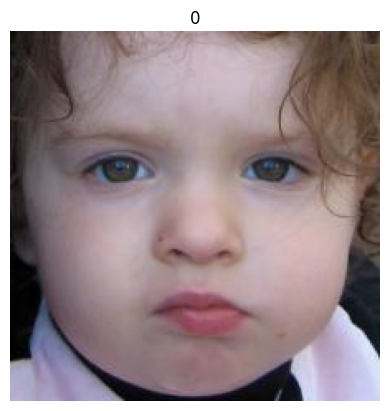

In [51]:
import matplotlib.pyplot as plt
import torch

# Define the mean and standard deviation used for normalization
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

# Get a batch of images
image_batch, label_batch = next(iter(test_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# Unnormalize the image
image = image * std[:, None, None] + mean[:, None, None]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis('off') # Turn off axis
plt.show()


In [52]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Initialize optimizer
optimizer = optim.Adam(params=pretrained_vit.parameters(), lr=0.0001)

# Initialize the scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Adjust step_size and gamma as needed

loss_fn = nn.CrossEntropyLoss()


In [53]:
import torch
from tqdm import tqdm
import os

def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, scheduler, epochs, device, checkpoint_dir="checkpoints"):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop with progress bar
        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{epochs}", unit='batch') as pbar:
            for images, labels in train_dataloader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()  # Zero the gradients
                outputs = model(images)  # Forward pass
                logits = outputs.logits
                loss = loss_fn(logits, labels)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update parameters

                running_train_loss += loss.item()

                # Calculate training accuracy
                _, predicted_train = torch.max(logits, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()

                pbar.set_postfix(loss=running_train_loss / (pbar.n + 1))  # Update the progress bar
                pbar.update(1)  # Update progress bar

        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                logits = outputs.logits
                loss = loss_fn(logits, labels)  # Compute validation loss
                running_val_loss += loss.item()

                # Calculate validation accuracy
                _, predicted_val = torch.max(logits, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

            epoch_val_loss = running_val_loss / len(val_dataloader)
            val_losses.append(epoch_val_loss)
            val_accuracy = correct_val / total_val
            val_accuracies.append(val_accuracy)
            print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            # Save checkpoint if validation accuracy improves
            if val_accuracy > best_accuracy:
                best_accuracy = save_checkpoint(model, epoch, val_accuracy, best_accuracy, checkpoint_dir)

        # Step the scheduler at the end of the epoch
        scheduler.step()

    return train_losses, train_accuracies, val_losses, val_accuracies

# Checkpoint function to save the model
def save_checkpoint(model, epoch, accuracy, best_accuracy, checkpoint_dir="checkpoints"):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}_acc_{accuracy:.4f}.pth")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")
    return accuracy  # Update the best accuracy


In [54]:
# Train the model with the scheduler
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    pretrained_vit, 
    train_dataloader, 
    val_dataloader, 
    optimizer, 
    loss_fn, 
    scheduler=scheduler,  # Pass the scheduler here
    epochs=10,
    device=device
)

Epoch 1/10: 100%|██████████| 1755/1755 [21:26<00:00,  1.36batch/s, loss=1.25]


Epoch [1/10], Train Loss: 1.2488, Train Accuracy: 0.5358
Validation Loss: 1.0178, Validation Accuracy: 0.6188
Checkpoint saved at checkpoints/model_epoch_1_acc_0.6188.pth


Epoch 2/10: 100%|██████████| 1755/1755 [21:37<00:00,  1.35batch/s, loss=1.02]


Epoch [2/10], Train Loss: 1.0234, Train Accuracy: 0.6249
Validation Loss: 0.9828, Validation Accuracy: 0.6332
Checkpoint saved at checkpoints/model_epoch_2_acc_0.6332.pth


Epoch 3/10: 100%|██████████| 1755/1755 [21:22<00:00,  1.37batch/s, loss=0.946]


Epoch [3/10], Train Loss: 0.9459, Train Accuracy: 0.6504
Validation Loss: 0.9778, Validation Accuracy: 0.6317


Epoch 4/10: 100%|██████████| 1755/1755 [21:37<00:00,  1.35batch/s, loss=0.887]


Epoch [4/10], Train Loss: 0.8866, Train Accuracy: 0.6732
Validation Loss: 0.9862, Validation Accuracy: 0.6367
Checkpoint saved at checkpoints/model_epoch_4_acc_0.6367.pth


Epoch 5/10: 100%|██████████| 1755/1755 [21:46<00:00,  1.34batch/s, loss=0.826]


Epoch [5/10], Train Loss: 0.8258, Train Accuracy: 0.6977
Validation Loss: 0.9468, Validation Accuracy: 0.6519
Checkpoint saved at checkpoints/model_epoch_5_acc_0.6519.pth


Epoch 6/10: 100%|██████████| 1755/1755 [21:58<00:00,  1.33batch/s, loss=0.651]


Epoch [6/10], Train Loss: 0.6506, Train Accuracy: 0.7600
Validation Loss: 0.9649, Validation Accuracy: 0.6635
Checkpoint saved at checkpoints/model_epoch_6_acc_0.6635.pth


Epoch 7/10: 100%|██████████| 1755/1755 [21:25<00:00,  1.36batch/s, loss=0.592]


Epoch [7/10], Train Loss: 0.5920, Train Accuracy: 0.7836
Validation Loss: 0.9936, Validation Accuracy: 0.6618


Epoch 8/10: 100%|██████████| 1755/1755 [21:52<00:00,  1.34batch/s, loss=0.547]


Epoch [8/10], Train Loss: 0.5475, Train Accuracy: 0.7978
Validation Loss: 1.0400, Validation Accuracy: 0.6590


Epoch 9/10: 100%|██████████| 1755/1755 [21:41<00:00,  1.35batch/s, loss=0.512]


Epoch [9/10], Train Loss: 0.5119, Train Accuracy: 0.8100
Validation Loss: 1.0777, Validation Accuracy: 0.6571


Epoch 10/10: 100%|██████████| 1755/1755 [21:57<00:00,  1.33batch/s, loss=0.475]


Epoch [10/10], Train Loss: 0.4750, Train Accuracy: 0.8247
Validation Loss: 1.1385, Validation Accuracy: 0.6520


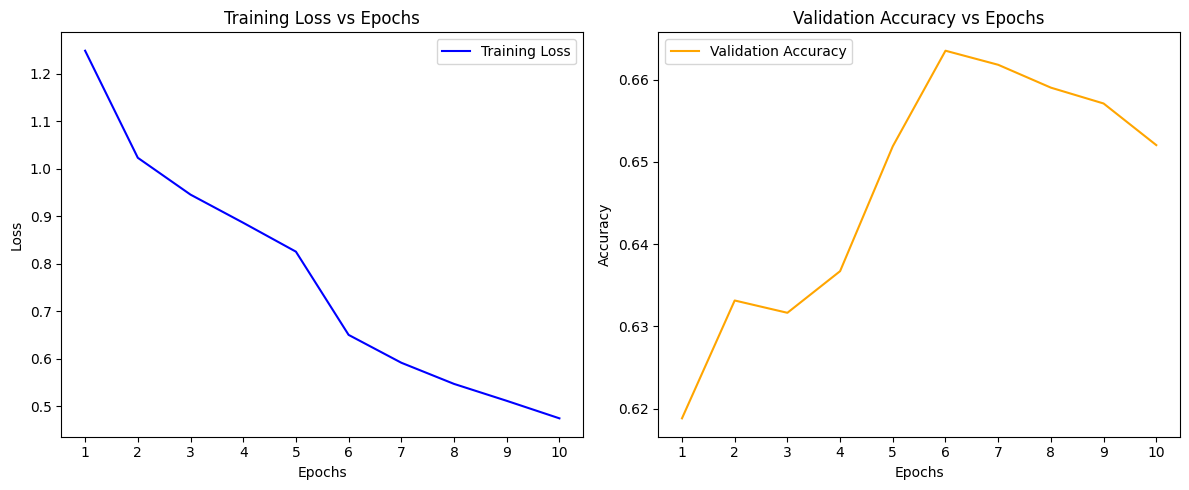

In [55]:

# Plotting Loss and Accuracy
def plot_metrics(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_metrics(train_losses, val_accuracies)

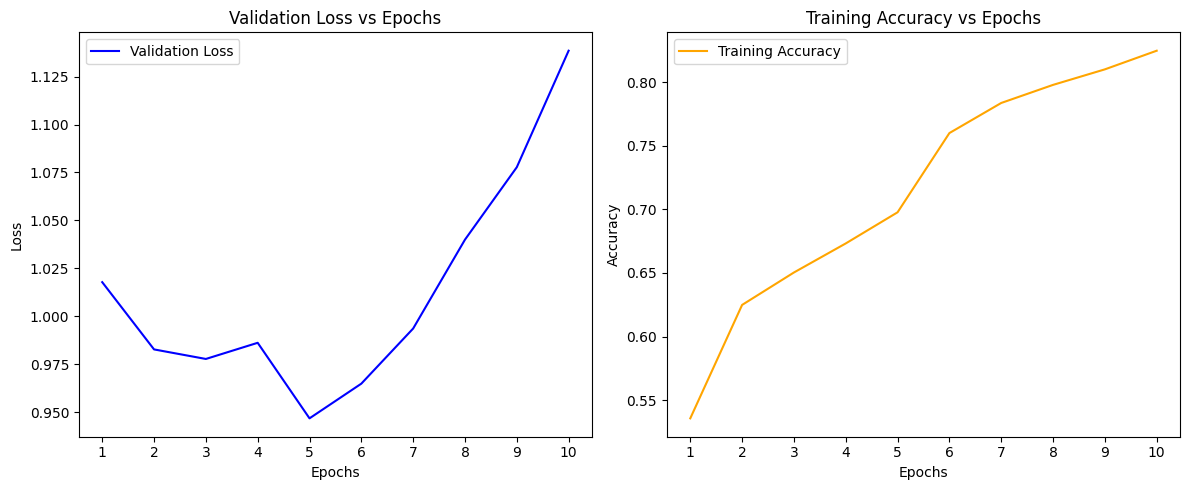

In [56]:

# Plotting Loss and Accuracy
def plot_metrics(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Validation Loss', color='blue')
    plt.title('Validation Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Training Accuracy', color='orange')
    plt.title('Training Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_metrics(val_losses, train_accuracies)

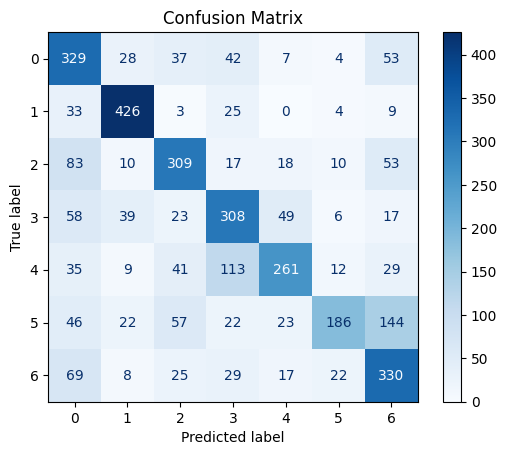

Classification Report:
              precision    recall  f1-score   support

           0     0.5038    0.6580    0.5707       500
           1     0.7860    0.8520    0.8177       500
           2     0.6242    0.6180    0.6211       500
           3     0.5540    0.6160    0.5833       500
           4     0.6960    0.5220    0.5966       500
           5     0.7623    0.3720    0.5000       500
           6     0.5197    0.6600    0.5815       500

    accuracy                         0.6140      3500
   macro avg     0.6351    0.6140    0.6101      3500
weighted avg     0.6351    0.6140    0.6101      3500



<Figure size 640x480 with 0 Axes>

In [61]:
import pandas as pd
# Function to plot confusion matrix
def plot_confusion_matrix(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("Classification Report:")
    print(report)

    # Convert classification report to DataFrame
    report_lines = report.split('\n')
    report_data = [line.split() for line in report_lines[2:-4]]  # Skip header and footer lines

    # Create a DataFrame
    report_df = pd.DataFrame(report_data, columns=['class', 'precision', 'recall', 'f1-score', 'support'])
    report_df.set_index('class', inplace=True)

    # Save the classification report to a CSV file
    report_df.to_csv('classification_report2.csv')

    plt.savefig("confusion2.png")
    
pretrained_vit.load_state_dict(torch.load('/kaggle/working/checkpoints/model_epoch_6_acc_0.6635.pth'))    
plot_confusion_matrix(pretrained_vit, test_dataloader, device)


In [ ]:
import shutil

# Define the source and destination paths
source = 'checkpoints/model_epoch_6_acc_0.6635.pth'
destination = '/kaggle/working/checkpointsADAM2/model_epoch_6_acc_0.6635.pth'

# Copy the file
shutil.copy(source, destination)


In [59]:
import pandas as pd

# Define data to save
data = {
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'train_accuracy': train_accuracies,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies
}

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_filename = 'training_metrics_ADAMtop.csv'
df.to_csv(csv_filename, index=False)

print(f"Training metrics saved to {csv_filename}")


Training metrics saved to training_metrics_ADAMtop.csv
